In [1]:
import sys
import time
from pyaxidraw import axidraw
import random
import numpy as np
import matplotlib.pyplot as plt
import PIL
from PIL import Image, ImageDraw
from skimage.io import imread, imshow
from skimage.color import rgb2hsv, rgb2gray, rgb2yuv
from skimage import color, exposure, transform
from skimage.exposure import equalize_hist
from skimage.transform import warp_polar
from skimage.util import crop
from skimage.filters import gaussian, sobel_h, sobel_v, sobel
from copy import copy


In [33]:
def create_path(image_angle, x_start, y_start, steps, step_interval, angle_offset = 0.0):
    path = []
    
    max_x = image_angle.shape[0] - 1
    max_y = image_angle.shape[1] - 1
    
    current_pos = (y_start, x_start)
    
    path.append((x_start, y_start))
    
    for step in range(steps):
        direction_angle = image_angle[current_pos[0] % max_x, current_pos[1] % max_y] + (np.pi / 2.0) +angle_offset
        y = (current_pos[0] + int(np.cos(direction_angle) * step_interval))
        x = (current_pos[1] + int(np.sin(direction_angle) * step_interval)) 
        if (y % max_x) != y:
            break
            
        if (x % max_y) != x:
            break
            
        current_pos = (y,x)
        path.append((x,y))
        
    return path

(559, 538, 3)


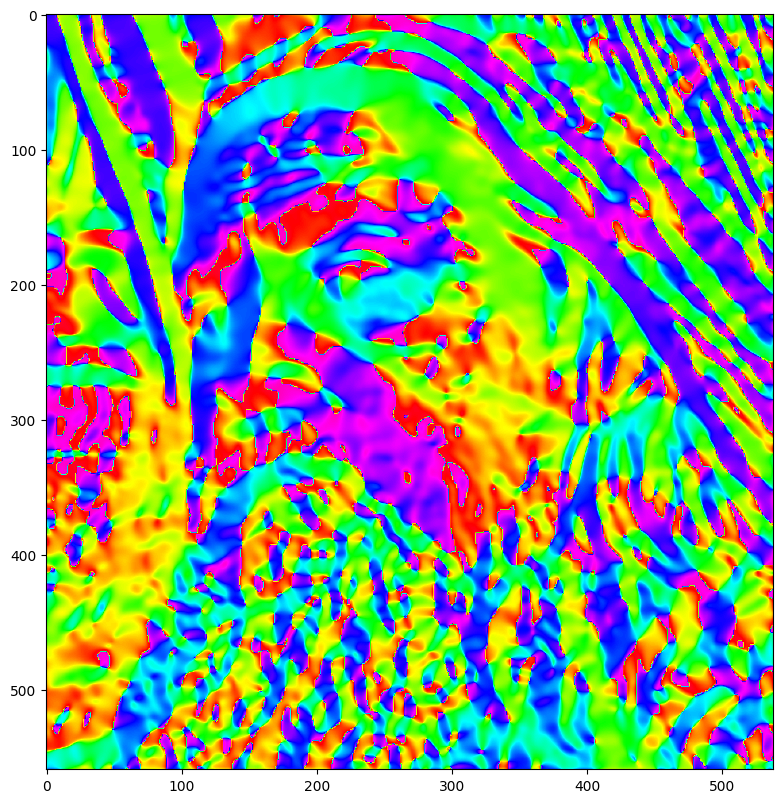

In [87]:
picture = imread('.\\data\\me_04.jpg')

#create vector field from image
sigma = 4

x_offset = 3.0
y_osset = 3.0

picture_gray = rgb2gray(picture)
picture_blur = gaussian(picture_gray, sigma=sigma)

picture_sobel_h = sobel_h(picture_blur)
picture_sobel_v = sobel_v(picture_blur)

picture_angle = np.arctan2(picture_sobel_v, picture_sobel_h)
plt.figure(num=None, figsize=(10, 10), dpi=100)
plt.imshow(picture_angle, cmap='gist_rainbow')

print(picture.shape)

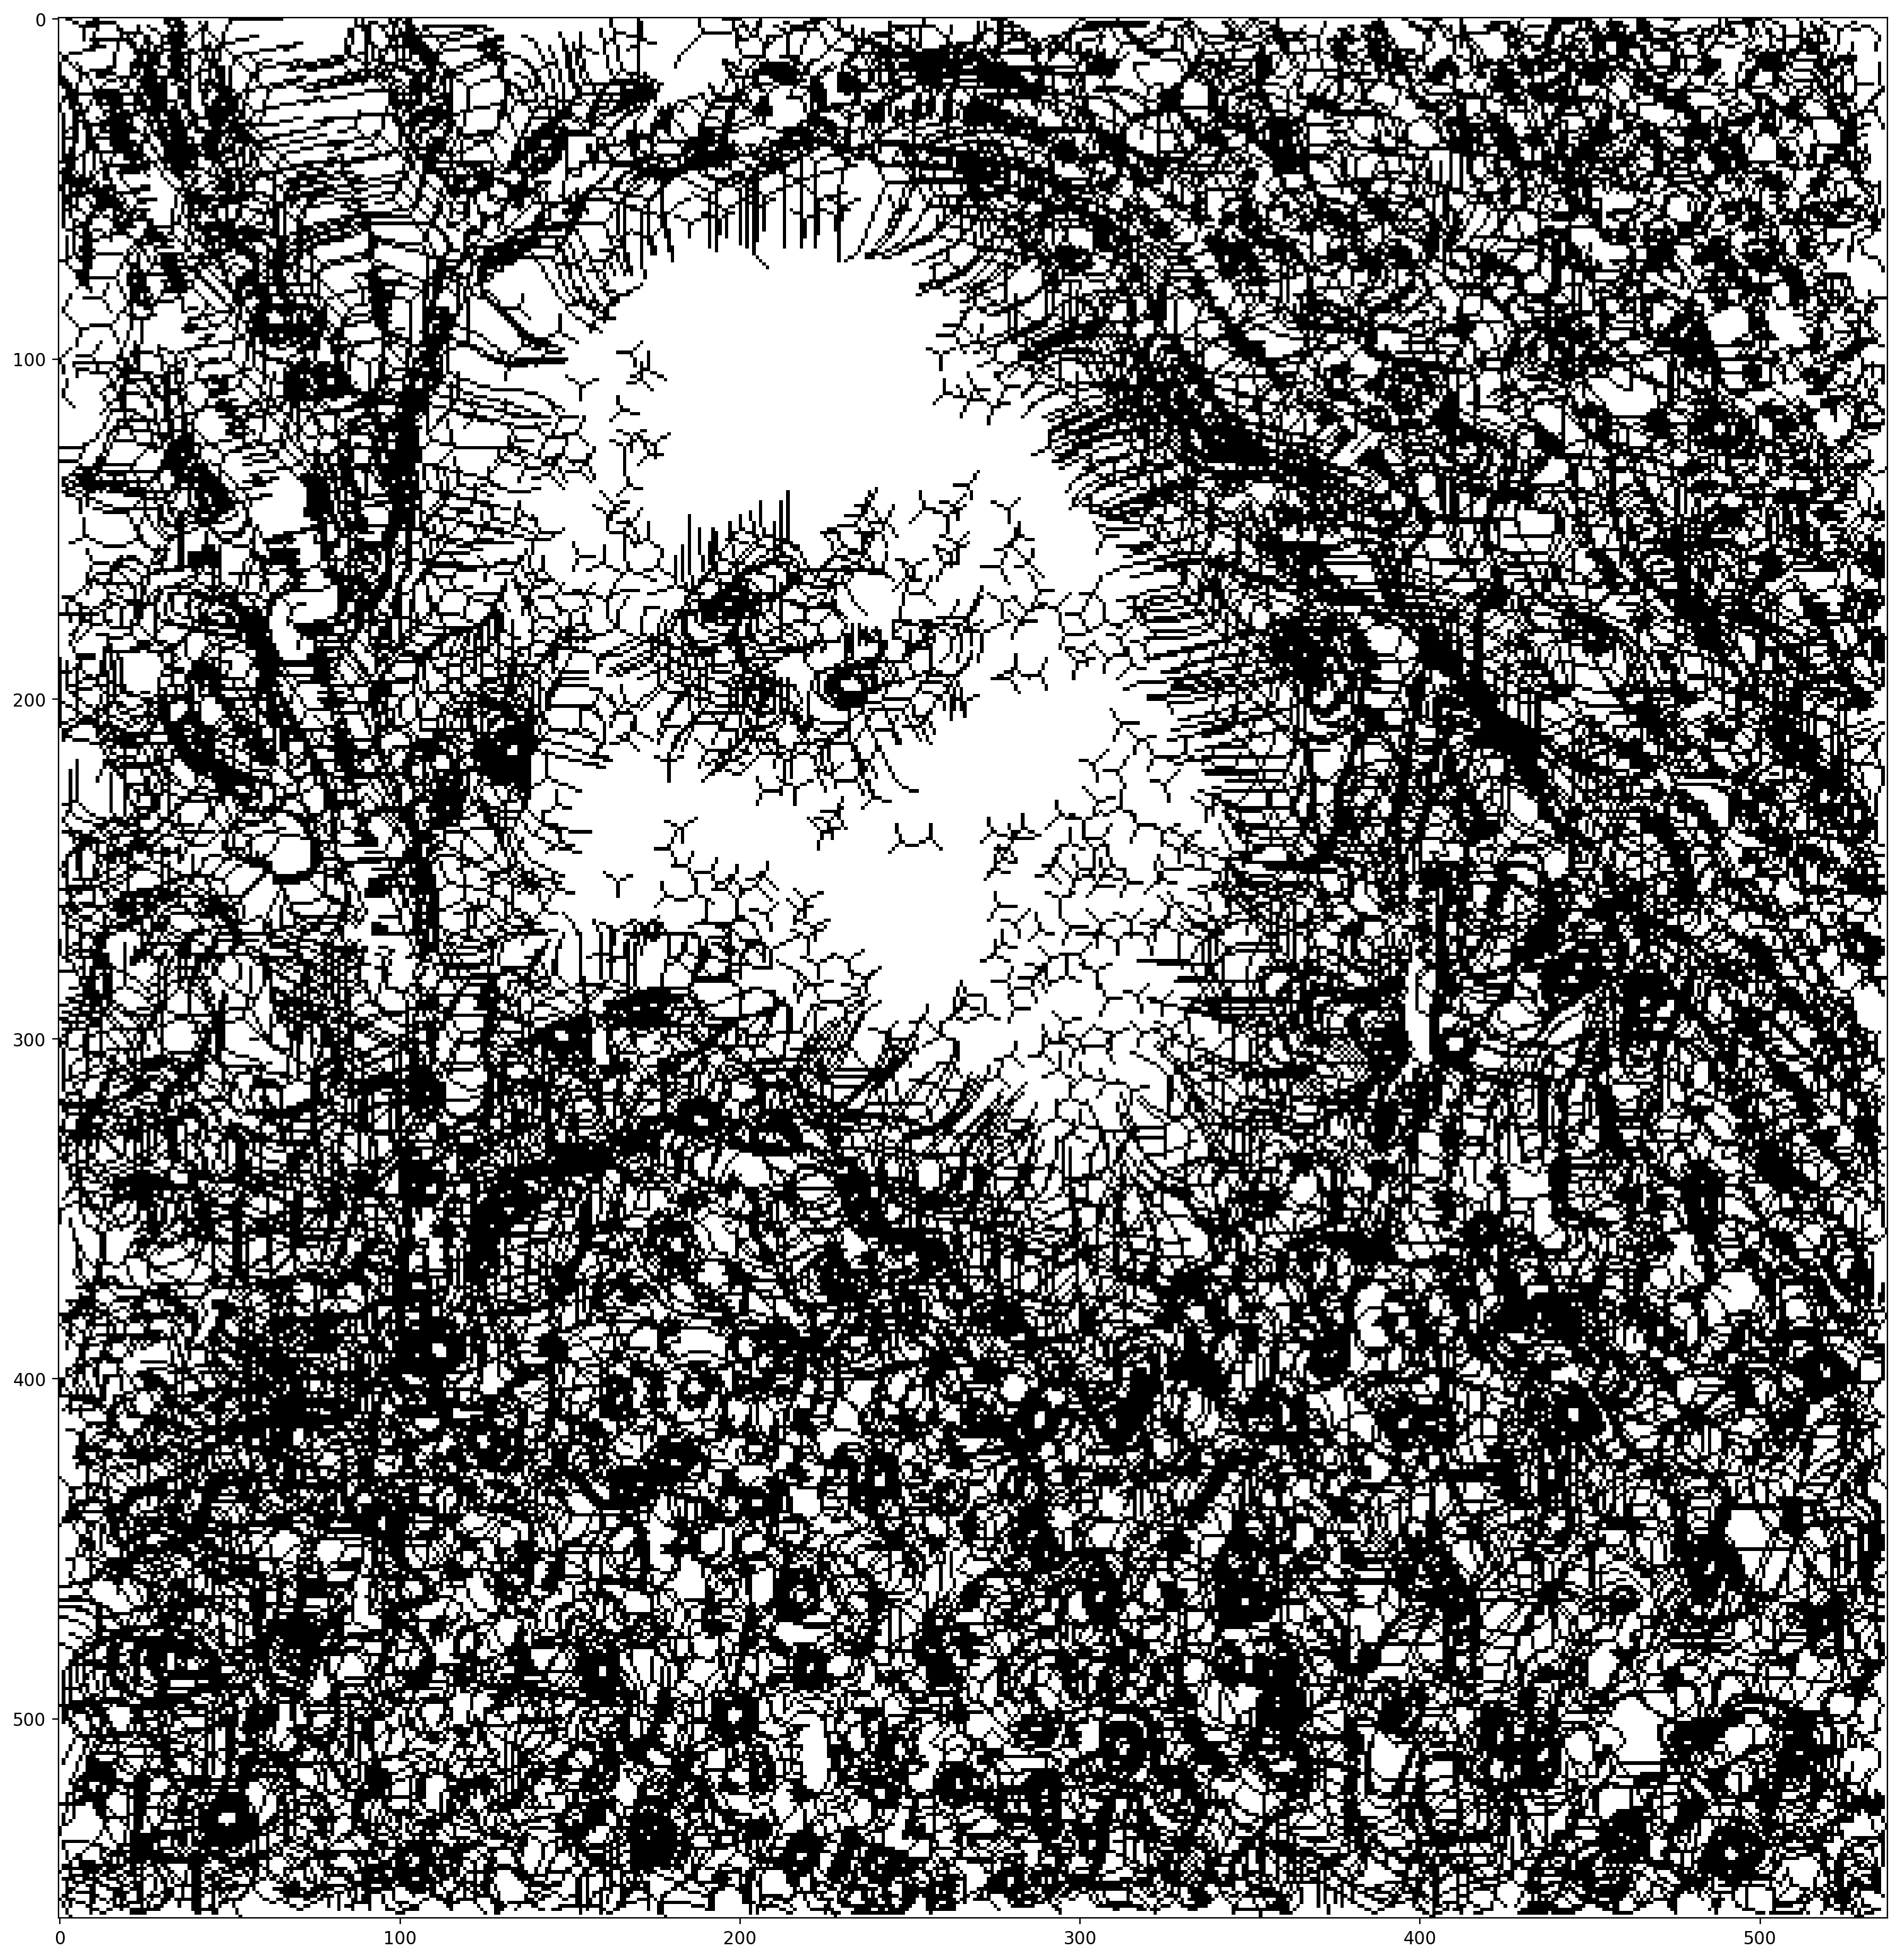

In [96]:
x_max = picture_angle.shape[1]
y_max = picture_angle.shape[0]

###                 PARAMETERS ###
light_threshold     = 0.998  #max amount of light to draw a path
probability         = 0.5 #probability that a path will spawn on pixel

gamma_probability   = 2.0  #gamma adjustment to gray scale value used for probability of spawning path on pixel
length_gamma        = 2.2  #gamma adjustment to gray scale used for length calculation
max_length          = 10   #maximum line length
step_size           = 5    #size of step between points

path_list = [] #list to contain paths

path_image = Image.new('1', (x_max, y_max), color=1) #image to display combined paths results

#loop through each pixel in image
for xp in range(x_max):
    for yp in range(y_max):
        
        #do not draw a path if the pixel is too bright
        if picture_gray[yp, xp] < light_threshold:
            
            pix_num = xp + (yp * y_max)
            #randomly select a pixel to draw
            if pix_num % 25 == 0:
                if random.random() < probability:

                    #randomly choose to draw the pixel based on the light level of the pixel
                    if random.random() > (picture_gray[yp, xp] ) ** gamma_probability:

                        #length of the path is longer in darker parts of the image
                        length = int( ((1.0 - picture_gray[yp, xp]) ** length_gamma) * max_length)

                        for an in range(3):
                            angle = (np.pi * (2.0/3.0) * an)
                            #generate a new path
                            path = create_path(picture_angle, xp, yp, length, step_size + random.randint(0,1), angle + (np.pi / 8.0))

                            #add the path to the image
                            draw = PIL.ImageDraw.Draw(path_image)
                            draw.line(path, width = 1, fill=0, joint="curve")

                            path_list.append(path)

#display the combined paths
plt.figure(num=None, figsize=(20, 20), dpi=200)
plt.imshow(path_image, cmap='gray')

In [5]:
def set_options(axis_draw):
    '''
    Sets the options for the axidraw given an axisdraw context
    '''
    ad = axis_draw
    ad.options.speed_pendown = 100  # Range: 1-110 (percent). 
    ad.options.speed_penup = 100    # Range: 1-110 (percent). 
    ad.options.accel = 95         # Range: 1-100 (percent). 
    ad.options.pen_pos_down = 10   # Range: 0-100 (percent). 
    ad.options.pen_pos_up = 40     # Range: 0-100 (percent).
    ad.options.pen_rate_lower = 95 # Range: 1-100 (percent).
    ad.options.pen_rate_raise = 95 # Range: 1-100 (percent).
    ad.options.pen_delay_down = 0 # Range: -500 - 500 (ms).
    ad.options.pen_delay_up = 0   # Range: -500 - 500 (ms).
    ad.options.units = 0 #units in inches
    ad.options.model = 2 #V3/A3 SE
    ad.update()


In [6]:
'''
Set up scale for AxiDraw
'''
picture_shape = [float(picture.shape[1]), float(picture.shape[0])]
paper_size = [11, 9] #size of image to print, the first number runs the length of the AxiDraw, second number is ortho, units is in optoins

scale = (np.min(paper_size) / np.max(picture.shape))

offset = [(paper_size[i] - (scale * picture_shape[i])) / 2.0 for i in range(2)]

print(scale)

0.00625


In [68]:
'''
Draw page and image borders
'''
ad = axidraw.AxiDraw()
ad.interactive()
set_options(ad)

connected = ad.connect()
if not connected:
    sys.exit()
print('starting')
#draw paper border
ad.moveto(0,0)
ad.lineto(0,paper_size[1])
ad.lineto(paper_size[0], paper_size[1])
ad.lineto(paper_size[0], 0)
ad.lineto(0,0)

#draw image border
ad.moveto(offset[0],offset[1])
ad.lineto(offset[0], offset[1] + image_size[1])
ad.lineto(offset[0] + image_size[0], offset[1] + image_size[1])
ad.lineto(offset[0] + image_size[0], offset[1])
ad.lineto(offset[0],offset[1])

ad.moveto(0,0)        
ad.disconnect()

print('complete')

starting
complete


In [7]:
'''
Sets the Axisdraw pen to up state
'''
ad = axidraw.AxiDraw()
ad.interactive()
set_options(ad)

connected = ad.connect()
if not connected:
    sys.exit()

ad.penup()
ad.disconnect()

Failed to connect to AxiDraw.


SystemExit: 

C:\Users\Ken_J\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py:3377: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


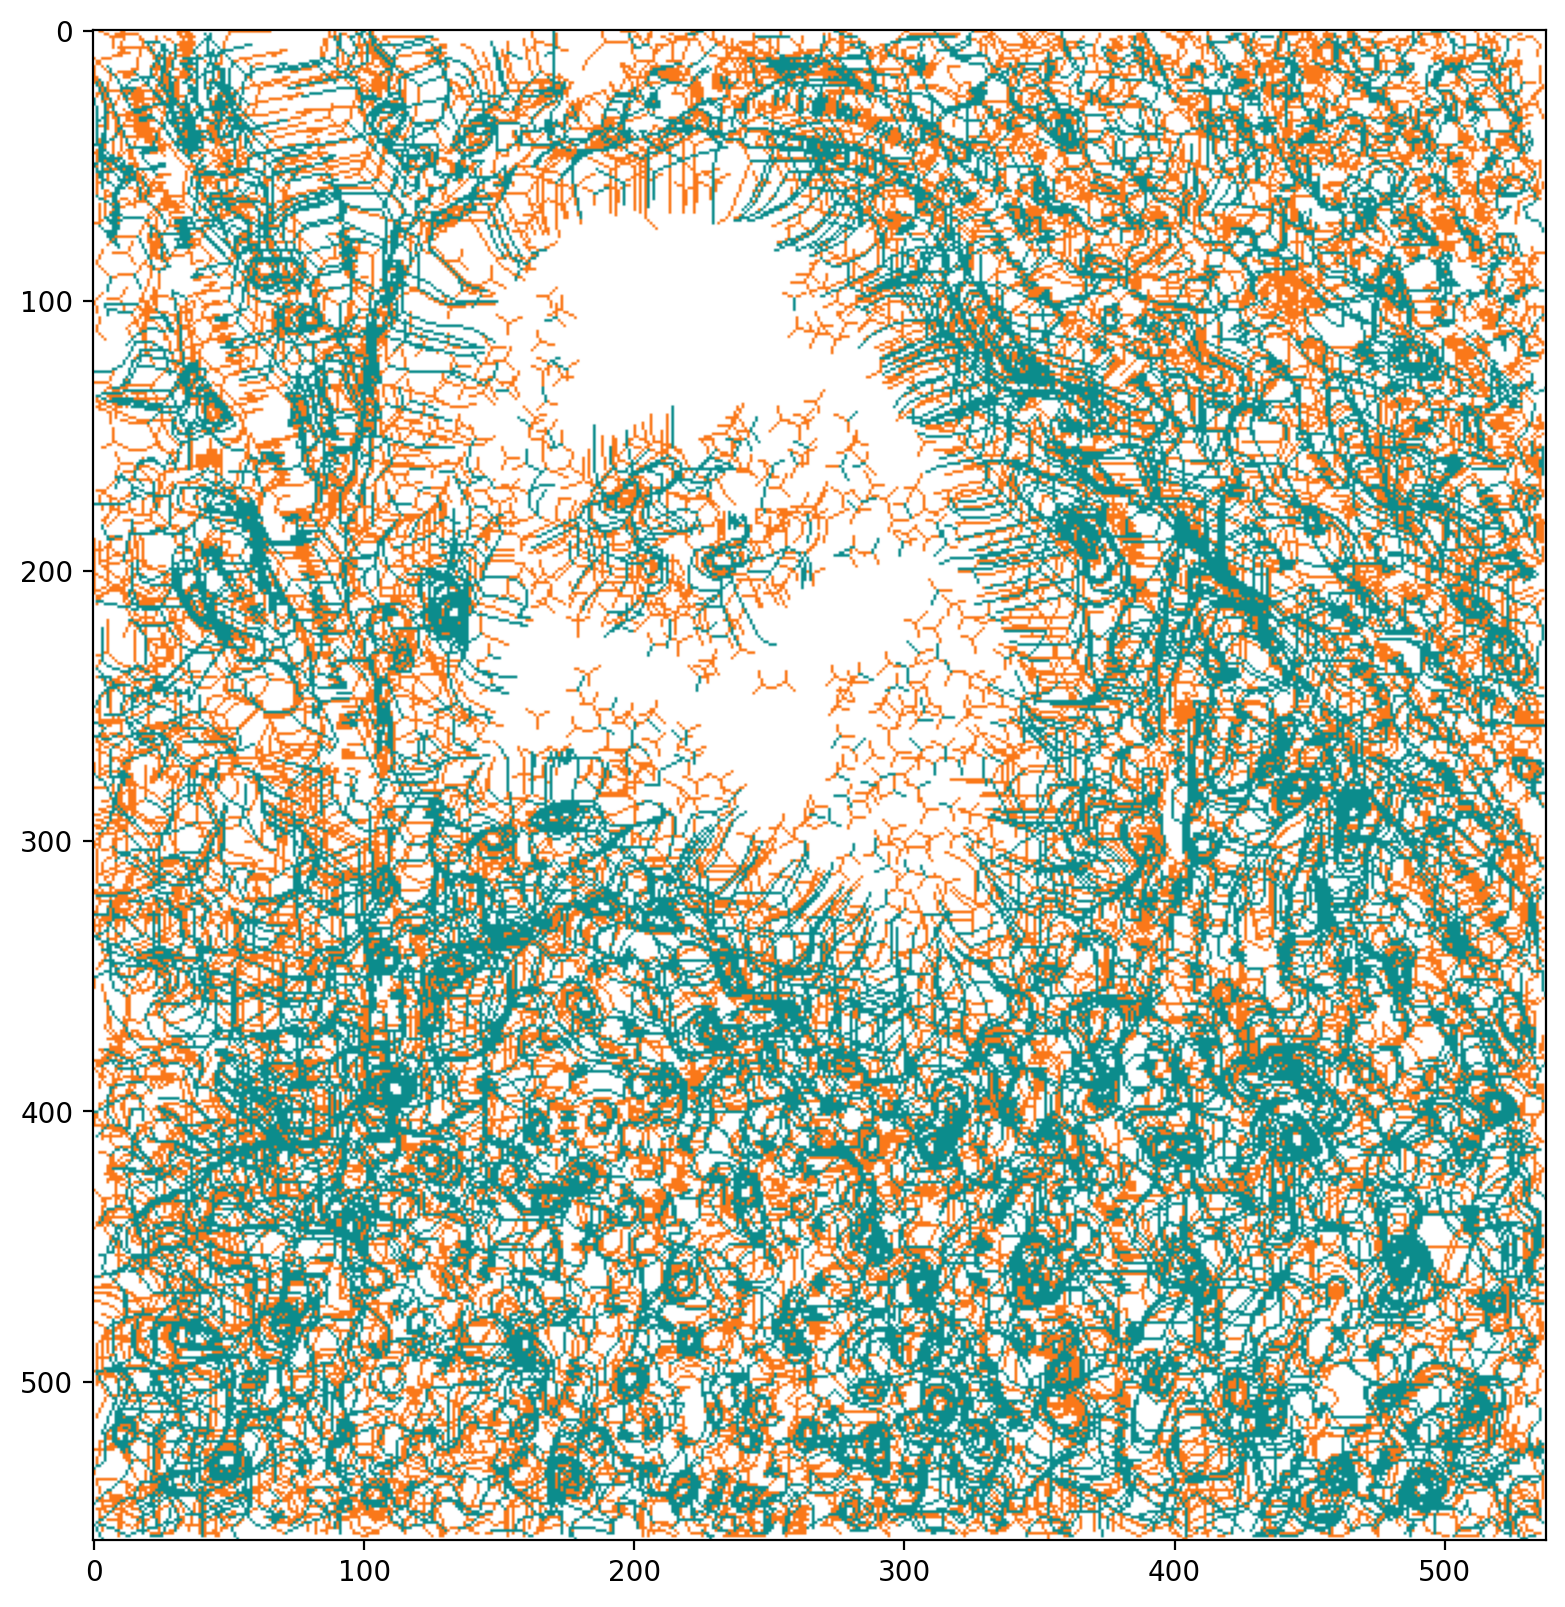

In [98]:
#probabilistically divide the middle and outside, creating a gradient
a = [np.mean(np.std(p, axis=(0))) for p in path_list]

big_dev = np.max(a)


middle_path_list = []
out_path_list = []
gradient_middle = [int(picture.shape[1] / 2.0), int(picture.shape[0] / 2.0)]
for p in path_list:
    dev = np.mean(np.std(p, axis=(0)))
    
    prob = dev / big_dev
    if random.random() > prob:
        middle_path_list.append(copy(p))
    else:
        out_path_list.append(copy(p))

path_image = Image.new('RGB', (x_max, y_max), color='rgb(255,255,255)') #image to display combined paths results   
draw = PIL.ImageDraw.Draw(path_image)

for path in middle_path_list:
    draw.line(path, width = 1, fill='rgb(250,120,25)', joint="curve")

for path in out_path_list:
    draw.line(path, width = 1, fill='rgb(12,140,140)', joint="curve")

#display the combined paths
plt.figure(num=None, figsize=(10, 10), dpi=200)
plt.imshow(path_image)

In [38]:
ad = axidraw.AxiDraw()
ad.interactive()
set_options(ad)

connected = ad.connect()
if not connected:
    sys.exit()
print('starting')
num = 0
for path in middle_path_list:
    num= num + 1
    x_pos = (path[0][1] * scale) + offset[1]
    y_pos = (path[0][0] * scale) + offset[0]
    ad.moveto(y_pos, x_pos)
    for point in path:
        x_pos = (point[1] * scale) + offset[1]
        y_pos = (point[0] * scale) + offset[0]
        ad.lineto(y_pos, x_pos)

ad.moveto(0,0)        
ad.disconnect()

print('complete')

starting
complete


In [39]:
ad = axidraw.AxiDraw()
ad.interactive()
set_options(ad)

connected = ad.connect()
if not connected:
    sys.exit()
print('starting')
num = 0
for path in out_path_list:
    num= num + 1
    x_pos = (path[0][1] * scale) + offset[1]
    y_pos = (path[0][0] * scale) + offset[0]
    ad.moveto(y_pos, x_pos)
    for point in path:
        x_pos = (point[1] * scale) + offset[1]
        y_pos = (point[0] * scale) + offset[0]
        ad.lineto(y_pos, x_pos)

ad.moveto(0,0)        
ad.disconnect()

print('complete')

starting
complete


230.06078760089264
